17190.31 13999.90 13537.02 13443.74 13417.90 13413.95 13406.74 13417.14 13412.77 13400.65 13404.57 13417.00 13398.43 13403.59 13403.37 13407.06 13410.59 13408.48 13408.05 13414.11 13410.02 13408.77 13410.77 13415.18 13406.19 13406.90 13405.23 13408.23 13409.94 13407.62 13403.00 13412.78 13409.43 13403.25 13406.57 13407.22 13405.03 13408.72 13413.12 13405.24 13407.60 13406.08 13410.70 13404.90 13409.45 13408.31 13411.51 13413.02 13401.48 13400.01 13419.82 13419.40 13425.69 13421.27 13401.11 13414.46 13409.85 13408.78 13401.61 13419.67 13409.36 13416.65 13409.06 13411.82 13410.55 13411.44 13403.63 13410.78 13418.85 13411.44 13398.48 13405.34 13402.81 13406.22 13411.70 13406.38 13430.10 13403.53 13413.68 13417.42 13408.65 13421.70 13412.09 13422.21 13409.21 13405.31 13421.93 13411.14 13416.51 13414.99 13406.20 13409.91 13407.05 13411.31 13410.35 13415.95 13407.55 13412.23 13415.19 13415.86 
16719.73 13216.01 12632.17 12532.14 12522.00 12524.89 12517.71 12519.77 12523.59 12512.59 12511.63 

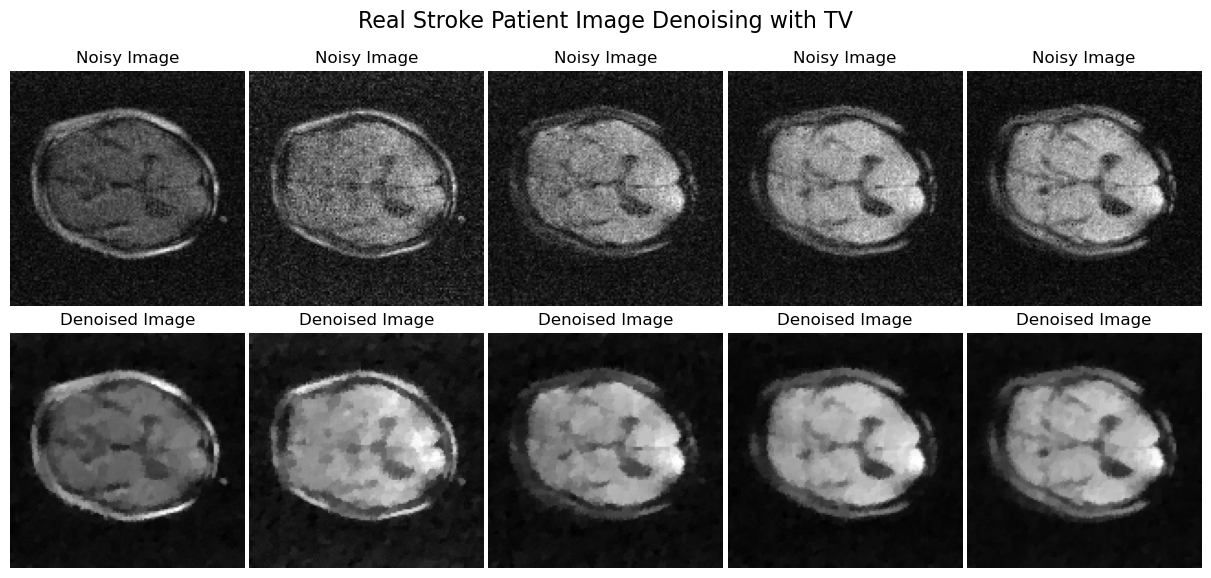

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.metrics import (
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
    mean_squared_error as mse
)

# Function to compute the gradient of an image
def compute_image_gradient(image):
    """Compute the gradient of an input image.
    
    Args:
        image (np.ndarray): The input image.
    
    Returns:
        np.ndarray: The gradient of the input image.
    """
    height, width = image.shape
    gradient = np.zeros((height, width, 2), image.dtype)
    gradient[:, :-1, 0] = image[:, 1:] - image[:, :-1]
    gradient[:-1, :, 1] = image[1:, :] - image[:-1, :]
    return gradient

# Function to compute the transpose of the gradient
def compute_transpose_gradient(gradient):
    """Compute the transpose of the gradient.
    
    Args:
        gradient (np.ndarray): The input gradient.
    
    Returns:
        np.ndarray: The transpose of the gradient.
    """
    height, width = gradient.shape[:2]
    transposed = np.zeros((height, width), gradient.dtype)
    transposed[:, :-1] -= gradient[:, :-1, 0]
    transposed[:, 1:] += gradient[:, :-1, 0]
    transposed[:-1] -= gradient[:-1, :, 1]
    transposed[1:] += gradient[:-1, :, 1]
    return transposed

# Function to compute the TV-L1 energy
def compute_TVL1_energy(denoised_image, original_image, regularization_weight):
    """Compute the TV-L1 energy of a denoised image.
    
    Args:
        denoised_image (np.ndarray): The denoised image.
        original_image (np.ndarray): The original noisy image.
        regularization_weight (float): The regularization parameter.
    
    Returns:
        float: The TV-L1 energy.
    """
    regularization_energy = np.sum(np.sqrt((compute_image_gradient(denoised_image) ** 2).sum(-1)))
    data_fidelity_energy = regularization_weight * np.sum(np.abs(denoised_image - original_image))
    return regularization_energy + data_fidelity_energy

# Function to project onto an R-radius ball
def project_onto_radius_ball(gradient_field, radius):
    """Project gradient vectors onto an R-radius ball.
    
    Args:
        gradient_field (np.ndarray): The gradient field.
        radius (float): The radius of the projection.
    
    Returns:
        np.ndarray: The projected gradient field.
    """
    normalized_gradient = np.maximum(1.0, np.sqrt((gradient_field ** 2).sum(-1)) / radius)
    return gradient_field / normalized_gradient[..., np.newaxis]

# Function to apply pixel-wise scalar shrinking
def shrink_scalar(X, forward_step, shrinkage_step_size):
    """Shrink values in a forward step array toward the values in the input array.
    
    Args:
        X (np.ndarray): The input array.
        forward_step (np.ndarray): The forward step array.
        shrinkage_step_size (float): The shrinkage step size.
    
    Returns:
        np.ndarray: The shrunk array.
    """
    return X + np.clip(forward_step - X, -shrinkage_step_size, shrinkage_step_size)

def solve_TVL1(img, clambda, iter_n=1000):
    L2 = 5.1
    tau = 0.025
    sigma = 3.0 / (L2 * tau)
    theta = 1.0
    denoised_image = image.copy()
    gradient_field = compute_image_gradient(denoised_image)
    
    for iteration in range(num_iterations):
        gradient_field = project_onto_radius_ball(gradient_field + sigma * compute_image_gradient(denoised_image), 1.0)
        new_image = shrink_scalar(denoised_image - tau * compute_transpose_gradient(gradient_field), image, lambda_weight * tau)
        denoised_image = new_image + theta * (new_image - denoised_image)
        
        if iteration % 10 == 0:
            energy = compute_TVL1_energy(denoised_image, image, lambda_weight)
            print(f"Iteration {iteration}: Energy = {energy:.2f}")
    
    return denoised_image


lambda_TVL1 = 1.4

def main():
    # Load noisy image data from the mat file
    mat = scipy.io.loadmat('../TraditionalMethods/medicaldata.mat')
    noisy_image_data = mat['data']

    # Plot the noisy and denoised images
    evol_time = noisy_image_data.shape[2]
    plt.figure(figsize=(12, 6))
    for j in range(evol_time):
        noisy_image = noisy_image_data[:, :, j]
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image
        # Denoise the image
        denoised_image = solve_TVL1(noisy_image_gray, lambda_TVL1, iter_n=1000)

        # Plot Noisy Image
        plt.subplot(2, noisy_image_data.shape[2], j + 1)
        noisy_image_gray_normalized = noisy_image_gray / 255 
        plt.imshow(noisy_image_gray_normalized, cmap='gray')
        plt.title('Noisy Image')
        plt.axis('off') 
        



        # Plot Denoised Image
        plt.subplot(2, noisy_image_data.shape[2], j + 1 + noisy_image_data.shape[2])
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised Image')
        plt.axis('off')
         # Save denoised image to file
        plt.imsave(f'denoised_image_TV{j + 1}.png', denoised_image, cmap='gray')

    
    plt.tight_layout(pad=0.3) 
    plt.subplots_adjust(top=0.92) 
    plt.suptitle('Real Stroke Patient Image Denoising with TV', fontsize=16)
    plt.show()

if __name__ == '__main__':
    main()

